<a href="https://colab.research.google.com/github/yannidd/ai-society-lstm-lecture/blob/master/extra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up libraries

In [1]:
# Select TensorFlow 2.
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

%matplotlib inline

TensorFlow 2.x selected.


In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [0]:
# Increase matplotlib font size.
font = {'size': 14}
matplotlib.rc('font', **font)

## Data

### Load

In [4]:
accel_data = np.genfromtxt('https://raw.githubusercontent.com/yannidd/ai-society-lstm-lecture/master/data.csv', delimiter=',')
print(f'Acceleration data shape: {accel_data.shape}.\n'
      f'First 3 columns are acceleration data (x, y, z).\n'
      f'Last column is the label.')

Acceleration data shape: (107362, 4).
First 3 columns are acceleration data (x, y, z).
Last column is the label.


### Visualise

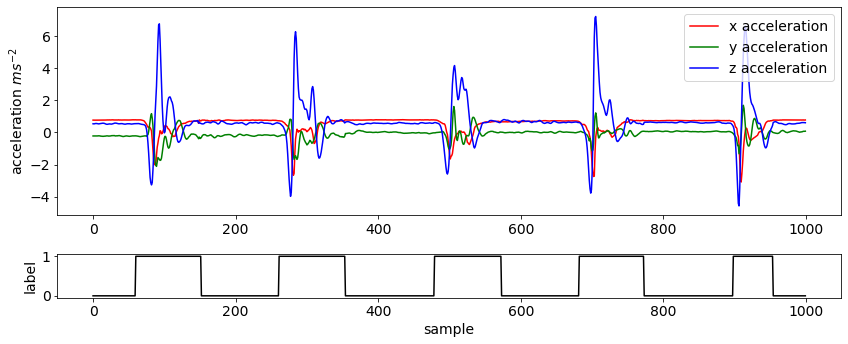

In [5]:
start = 500 #@param {type:"slider", min:0, max:107362, step:1}
length = 1000 #@param {type:"slider", min:0, max:5000, step:1}
end = start + length

fig = plt.figure(figsize=(12, 5))
ax0 = plt.subplot2grid((4, 1), (0, 0), 3, 1)
ax1 = plt.subplot2grid((4, 1), (3, 0), 1, 1)

ax0.plot(accel_data[start:end, 0], 'r')
ax0.plot(accel_data[start:end, 1], 'g')
ax0.plot(accel_data[start:end, 2], 'b')
ax1.plot(accel_data[start:end, 3], 'k')

ax0.set_ylabel(r'acceleration $ms^{-2}$')
ax1.set_xlabel('sample')
ax1.set_ylabel('label')

ax0.legend(['x acceleration','y acceleration','z acceleration'], loc=1)

plt.tight_layout()
plt.show()

### Prepare for training

In [6]:
x = accel_data[:, :3][:, np.newaxis, :]
y = to_categorical(accel_data[:, 3], num_classes=2, dtype='float32')
print(f'x shape: {x.shape}\n'
      f'y shape: {y.shape}')

x shape: (107362, 1, 3)
y shape: (107362, 2)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, 
                                                    shuffle=False)
print(f'x_train shape: {x_train.shape}\n'
      f'x_test shape:  {x_test.shape}\n'
      f'y_train shape: {y_train.shape}\n'
      f'y_test shape:  {y_test.shape}')

x_train shape: (75153, 1, 3)
x_test shape:  (32209, 1, 3)
y_train shape: (75153, 2)
y_test shape:  (32209, 2)


## TensorFlow model

In [0]:
def make_model(name, stateful: bool=False):
  model = Sequential(name=name)

  model.add(LSTM(
    64,
    activation='tanh', 
    input_shape=(None, 3), 
    batch_input_shape=(1 if stateful else None, None, 3),
    unit_forget_bias=True, 
    return_sequences=True,
    stateful=stateful
    ))

  model.add(LSTM(
    32, 
    activation='tanh', 
    unit_forget_bias=True,
    stateful=stateful
    ))

  model.add(Dense(
    16, 
    activation='relu'
    ))
  model.add(Dense(
    2, 
    activation='softmax', 
    name='output_layer'
    ))

  for layer in model.layers:
    layer.regularizers = regularizers.l2(l=0.0015)

  return model

### Fitting

In [0]:
training_model = make_model('training_model')
training_model.compile(loss = 'categorical_crossentropy',
                       optimizer = 'adam',
                       metrics = ['accuracy'])
training_model.summary()

Model: "training_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          17408     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
output_layer (Dense)         (None, 2)                 34        
Total params: 30,386
Trainable params: 30,386
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 75153 #@param {type:"integer"}
epochs = 500 #@param {type:"integer"}

history = training_model.fit(x=x_train, 
                             y=y_train,
                             epochs=epochs,
                             validation_data=(x_test, y_test),
                             batch_size=batch_size)

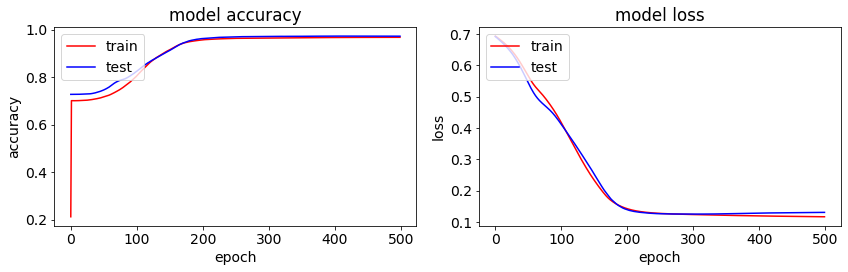

In [0]:
fig = plt.figure(figsize=(12, 4))
ax0 = plt.subplot2grid((1, 2), (0, 0), 1, 1)
ax1 = plt.subplot2grid((1, 2), (0, 1), 1, 1)

# Plot training & validation accuracy values
ax0.plot(history.history['accuracy'], 'r')
ax0.plot(history.history['val_accuracy'], 'b')
ax0.set_title('model accuracy')
ax0.set_ylabel('accuracy')
ax0.set_xlabel('epoch')
ax0.legend(['train', 'test'], loc='upper left')

# Plot training & validation loss values
ax1.plot(history.history['loss'], 'r')
ax1.plot(history.history['val_loss'], 'b')
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

plt.tight_layout()
plt.show()

### Predicting

In [0]:
inference_model_stateful = make_model('inference_model', stateful=True)
inference_model_stateless = make_model('inference_model', stateful=False)
inference_model_stateful.set_weights(training_model.get_weights())
inference_model_stateless.set_weights(training_model.get_weights())

In [0]:
start = 500 #@param {type:"slider", min:0, max:107362, step:1}
length = 1000 #@param {type:"slider", min:0, max:5000, step:1}
end = start + length

prediction_stateful = np.concatenate(
    [inference_model_stateful.predict(np.array([i])) for i in x[start:end]])
prediction_stateless = np.concatenate(
    [inference_model_stateless.predict(np.array([i])) for i in x[start:end]])

### Visualising prediction

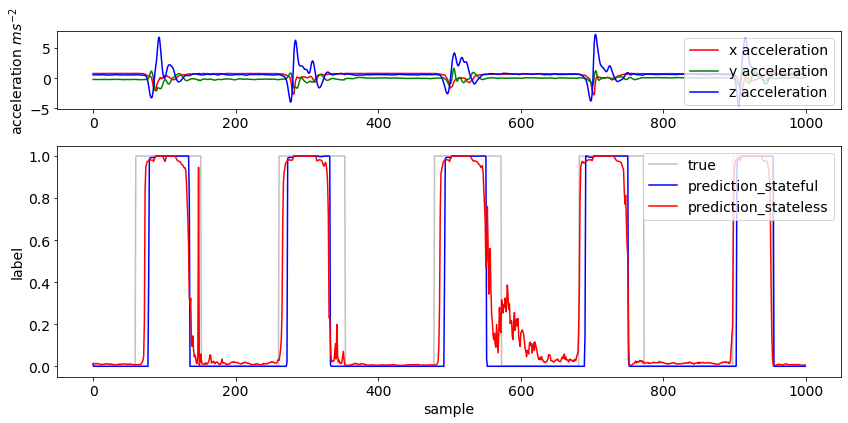

In [0]:
fig = plt.figure(figsize=(12, 6))
ax0 = plt.subplot2grid((10, 1), (0, 0), 3, 1)
ax1 = plt.subplot2grid((10, 1), (3, 0), 7, 1)

ax0.plot(accel_data[start:end, 0], 'r')
ax0.plot(accel_data[start:end, 1], 'g')
ax0.plot(accel_data[start:end, 2], 'b')
ax1.plot(accel_data[start:end, 3], 'silver')
ax1.plot(prediction_stateful[:, 1], 'b')
ax1.plot(prediction_stateless[:, 1], 'r')

ax0.set_ylabel(r'acceleration $ms^{-2}$')
ax1.set_xlabel('sample')
ax1.set_ylabel('label')

ax0.legend(['x acceleration','y acceleration','z acceleration'], loc=1)
ax1.legend(['true', 'prediction_stateful', 'prediction_stateless'], loc=1)

plt.tight_layout()
plt.show()

### A different approach to fitting

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



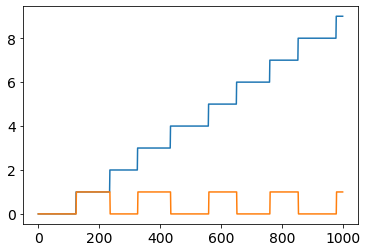

In [16]:
x_new = np.cumsum(np.abs(np.diff(accel_data[:, 3])))
B = np.split(accel_data, np.where(accel_data[:, 3] == 0.0)[0][1:])
plt.plot(x_new[:1000])
plt.plot(accel_data[:1000, 3])
print(B)

In [17]:
print(B)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

